In [1]:
import jax

jax.config.update("jax_enable_x64", True)
#execute only with gpu and if extra accuracy needed


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import jax
import jax.numpy as jnp
import os
import json
import types
import timeit
import scipy
import scipy.constants
import time
from jax.scipy.integrate import trapezoid

# parameters of the process
backend = "tpu"
batch_size = 10
devices = jax.devices()
num_devices = jax.device_count()
num_L = 320
num_theta = 20
num_phi=20
num_phi1 = 180
num_phi2 = 180
num_sigma1xr = 320
paral_factor = num_sigma1xr // num_devices
assert num_sigma1xr % num_devices == 0  , "num_sigma1xr must be divisible by num_devices"
assert paral_factor % batch_size == 0, "paral_factor must be divisible by batch_size"

def max_after_inf(arr):
    # Replace inf and NaN with -inf
    modified_arr = jnp.where(jnp.isinf(arr) | jnp.isnan(arr), -jnp.inf, arr)
    # Find the maximum value
    max_value = jnp.max(modified_arr)
    return max_value


# %%


# define constants
e0 = scipy.constants.epsilon_0
mu0 = scipy.constants.mu_0
c = scipy.constants.c
eta0 = scipy.constants.physical_constants["characteristic impedance of vacuum"][0]
l = 1  # wavelength
f = c / l  # frequency
omega = 2 * jnp.pi * f
k0 = omega / c


def cos(x):
    return jnp.cos(x)


def sin(x):
    return jnp.sin(x)


def tan(x):
    return jnp.tan(x)


def exp(x):
    return jnp.exp(x)


def sqrt(x):
    return jnp.sqrt(x)


def sec(x):
    return 1 / jnp.cos(x)


def cot(x):
    return 1 / jnp.tan(x)


def Csc(x):
    return 1 / jnp.sin(x)


# %%
def create_dynamic_function(args, function_body, default_values=None):

    if default_values is None:
        default_values = {}

    # Separate args into those with and without default values
    args_with_defaults = []
    args_without_defaults = []
    for arg in args:
        if arg in default_values:
            args_with_defaults.append(f"{arg}={default_values[arg]}")
        else:
            args_without_defaults.append(arg)

    # Combine args, ensuring those with defaults come last
    all_args = args_without_defaults + args_with_defaults

    code = f"def dynamic_function({', '.join(all_args)}):\n    {function_body}"
    local_dict = {}
    exec(code, globals(), local_dict)

    return local_dict["dynamic_function"]


def extract_formulas(input_json):
    with open(input_json, "r") as f:
        data = json.load(f)
    Rx = data["Rx"]
    Ry = data["Ry"]
    Tx = data["Tx"]
    Ty = data["Ty"]
    return Rx, Ry, Tx, Ty


filepath="/kaggle/input/metasurfaces-optimization/results_general_real_xy_CONVERTED.json"

formulas = extract_formulas(filepath)
# %%
# Define parameter lists
params = ["phi1", "phi2", "sigma1xr", "L", "theta", "phi", "eta0", "k0","sigma1yr"]  #adjust this list if we have more arguments. In this case we kept Re(σ_y) at a constant value
# and optimized across L and Re(σ_x)

# Map function names to their formula indices
formulas_indices = {"Rx": 0, "Ry": 1, "Tx": 2, "Ty": 3}

# Map function names to their parameter lists
params_dict = {"Rx": params, "Ry": params, "Tx": params, "Ty": params}


# Default values arguments, or parameters
default_values = {"k0": k0, "eta0": eta0,"sigma1yr":5/eta0}

functions = {}

# Create and JIT compile functions dynamically
for key, index in formulas_indices.items():
    function_body = f"""
    return {formulas[index]}
    """
    functions[key] = jax.jit(
        create_dynamic_function(params_dict[key], function_body, default_values),
        backend=backend,
    )
# Unpack functions
Rx, Ry, Tx, Ty = functions["Rx"], functions["Ry"], functions["Tx"], functions["Ty"]



def func1(args):   #this is the function to be integrated to give the absorption
    x1, x2, x3, x4, theta, phi = args
    return (
        15
        * cos(theta)
        * (
            3
            - 4 * abs(Ry(x1, x2, x3, x4, theta, phi)) ** 2
            - 4 * abs(Ty(x1, x2, x3, x4, theta, phi)) ** 2
            + cos(4 * theta)
            - 4
            * (
                abs(Rx(x1, x2, x3, x4, theta, phi)) ** 2
                + abs(Tx(x1, x2, x3, x4, theta, phi)) ** 2
            )
            * sec(theta) ** 2
            + 2 * cos(2 * phi) * sin(2 * theta) ** 2
        )
    ) / (22 * jnp.pi)


func_1 = jax.jit(func1, backend=backend)



def custom_max(x1_grid, x2_grid, x3_grid, x4_grid, theta,phi):  #this is a function that computes the max and the values of φ1,φ2 where it occurs.
    #if there are more arguments, it need modification
    dth = theta[1] - theta[0]
    dph=phi[1]-phi[0]

    # Compute the function f over the 5D grid
    f = trapezoid(trapezoid(func_1((x1_grid, x2_grid, x3_grid, x4_grid, theta,phi)), dx=dth, axis=-1),dx=dph,axis=-1)

    # Find the index of the maximum value of f along the first axis (axis 0)
    ind_max_axis0 = jnp.argmax(f, axis=0, keepdims=True)
    x1_max_axis0 = jnp.take_along_axis(
        x1_grid[:, :, :, :,0, 0], ind_max_axis0, axis=0
    ).squeeze()
    x2_max_axis0 = jnp.take_along_axis(
        x2_grid[:, :, :, :, 0,0], ind_max_axis0, axis=0
    ).squeeze()
    f_max_axis0 = jnp.take_along_axis(f, ind_max_axis0, axis=0).squeeze()

    # Find the index of the maximum value of the reduced function f1 along the first axis (axis 1)
    ind_max_axis1 = jnp.argmax(f_max_axis0, axis=0, keepdims=True)
    x1_max = jnp.take_along_axis(x1_max_axis0, ind_max_axis1, axis=0).squeeze()
    x2_max = jnp.take_along_axis(x2_max_axis0, ind_max_axis1, axis=0).squeeze()
    f_max = jnp.take_along_axis(f_max_axis0, ind_max_axis1, axis=0).squeeze()

    return f_max, x1_max, x2_max


custom_max_jit = jax.jit(custom_max, backend=backend)


def compute_subgrid_max(indices, x1, x2, x3, x4, theta,phi):
    #compute the max and the corresponding values in a batched manner 
    i, j = indices

    dth = theta[1] - theta[0]
    
    dph=phi[1]-phi[0]

    x3_start = i * batch_size
    x4_start = j * batch_size
    x3_slice = jax.lax.dynamic_slice(x3, (x3_start,), (batch_size,))
    x4_slice = jax.lax.dynamic_slice(x4, (x4_start,), (batch_size,))

    x1_grid, x2_grid, x3_grid, x4_grid, _ ,_= jnp.meshgrid(
        x1, x2, x3_slice, x4_slice, theta,phi, indexing="ij"
    )

    subgrid_max, phi1_max, phi2_max = custom_max_jit(
        x1_grid, x2_grid, x3_grid, x4_grid, theta,phi
    )
    return subgrid_max, phi1_max, phi2_max


compute_subgrid_max_jit = jax.jit(compute_subgrid_max, backend=backend)


def outer_loop(i, args):
    j, x1, x2, x3, x4, theta,phi, results, phi1, phi2 = args
    subgrid_max, phi1_max, phi2_max = compute_subgrid_max_jit(
        (i, j), x1, x2, x3, x4, theta,phi
    )
    start_indices = (i * batch_size, j * batch_size)
    results = jax.lax.dynamic_update_slice(results, subgrid_max, start_indices)
    phi1 = jax.lax.dynamic_update_slice(phi1, phi1_max, start_indices)
    phi2 = jax.lax.dynamic_update_slice(phi2, phi2_max, start_indices)
    return (j, x1, x2, x3, x4, theta,phi, results, phi1, phi2)


outer_loop_jit = jax.jit(outer_loop, backend=backend)


def inner_loop(j, args):
    x1, x2, x3, x4, theta,phi, results, phi1, phi2 = args
    _,_, _, _, _, _, _, results, phi1, phi2 = jax.lax.fori_loop(
        0,
        int(len(x3) / batch_size),
        outer_loop_jit,
        (j, x1, x2, x3, x4, theta,phi, results, phi1, phi2),
    )
    return (x1, x2, x3, x4, theta,phi, results, phi1, phi2)


inner_loop_jit = jax.jit(inner_loop, backend=backend)


def main_loop(x3, x4):
    x1 = jnp.linspace(0 + 0.0001, jnp.pi - 0.00012, num=num_phi1)  # phi1_range
    x2 = jnp.linspace(0 + 0.00013, jnp.pi - 0.00011, num=num_phi2)  # phi2_range
    theta = jnp.linspace(0.0001, np.pi / 2, num_theta)           # theta
    phi=jnp.linspace(0, jnp.pi/2, num_phi,endpoint=True)        # phi
     
    results = jnp.empty((paral_factor, num_L))  # Initialize results array
    phi1 = jnp.empty((paral_factor, num_L))
    phi2 = jnp.empty((paral_factor, num_L))
    _,_, _, _, _, _, results, phi1, phi2 = jax.lax.fori_loop(
        0,
        int(len(x4) / batch_size),
        inner_loop_jit,
        (x1, x2, x3, x4, theta,phi, results, phi1, phi2),
    )
    return results, phi1, phi2


main_loop_jit = jax.pmap(
    jax.jit(main_loop, backend=backend),
    in_axes=(0, None),
    out_axes=(0, 0, 0),
    backend=backend,
)

In [9]:
sigma1yr_range = jnp.linspace(0.2 / eta0, 5 / eta0, num=num_sigma1xr).reshape(
    num_devices, paral_factor
)
L_range = jnp.linspace(0.05 * l, 1.5 * l, num=num_L)

In [10]:
time1=time.time()
results_final,phi1_final,phi2_final=main_loop_jit(sigma1yr_range,L_range)
time2=time.time()
print(time2-time1)
time3=time.time()
results_host = jax.device_get(results_final)
time4=time.time()
print(time4-time3)

0.014121770858764648
711.6619439125061


In [11]:
results_final,phi1_final,phi2_final = np.concatenate(results_final[:, :paral_factor, :], axis=0),np.concatenate(phi1_final[:, :paral_factor, :], axis=0),np.concatenate(phi2_final[:, :paral_factor, :], axis=0)
np.save("results_final.npy", results_final)
np.save("phi1_final.npy", phi1_final)
np.save("phi2_final.npy", phi2_final)

0.8918716


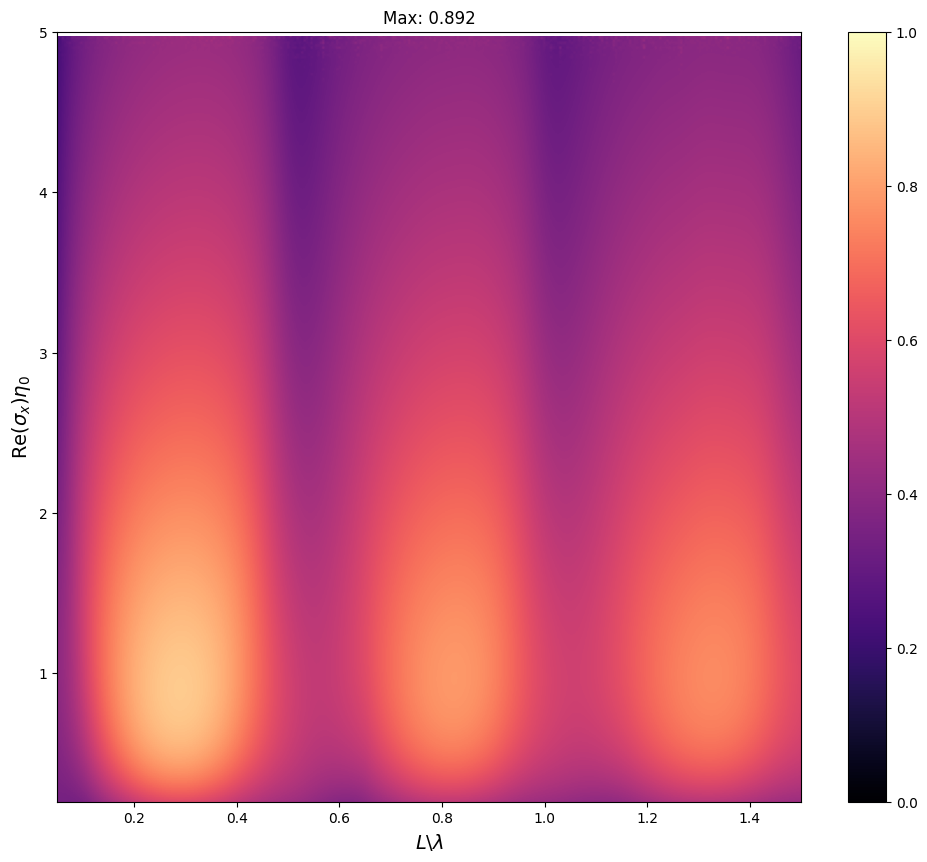

In [18]:
x4 = np.array(L_range)
x3 = np.array(sigma1yr_range).reshape(num_sigma1xr,1)
# Define the range for the colormap
vmax = jnp.max(max_after_inf(results_final))  # Maximum value for colormap
print(vmax)

plt.figure(figsize=(12,10))
plt.imshow(
    results_final,
    extent=[x4[0], x4[-1], x3[0] * eta0, x3[-1] * eta0],
    aspect="auto",
    cmap="magma",
    origin="lower",
    vmin=0,
    vmax=1,
)
plt.colorbar()
plt.title("Max: {:.3f}".format(vmax))
plt.ylabel(r'$\mathrm{Re}(\sigma_{x}) \eta_0$', fontsize=14)
plt.xlabel(r"$L\backslash λ$", fontsize=14)
plt.savefig("/kaggle/working/results.png")
plt.show()

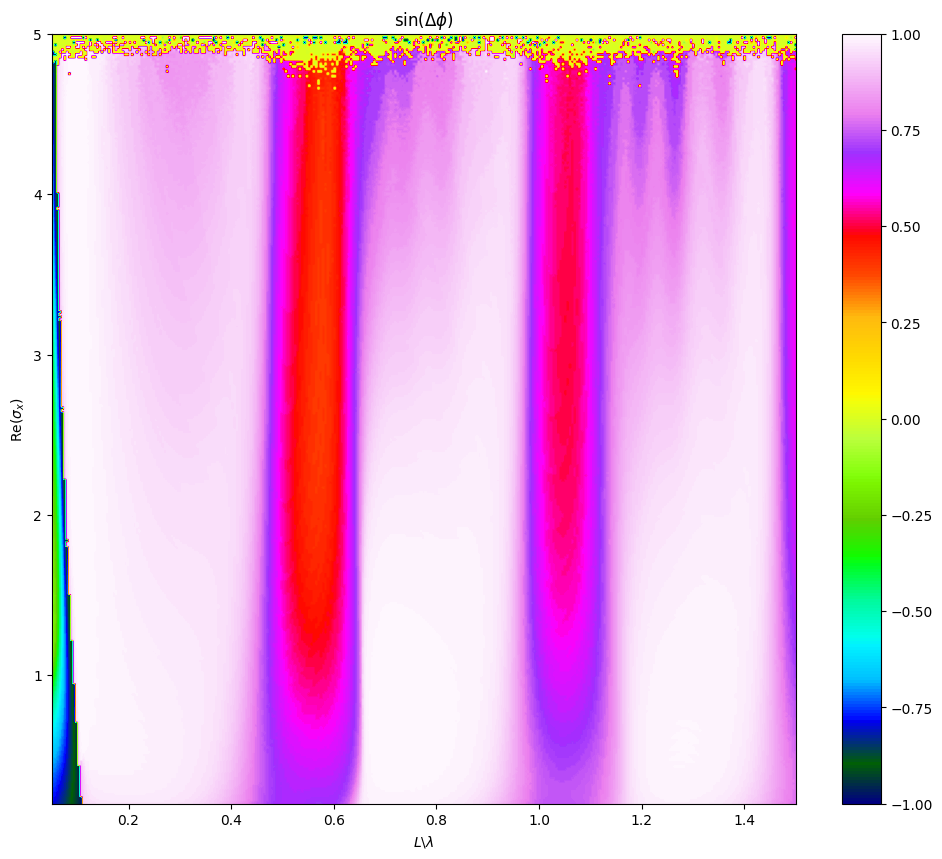

In [23]:
x4 = np.array(L_range)
x3 = np.array(sigma1yr_range).reshape(num_sigma1xr,1)
# Define the range for the colormap

plt.figure(figsize=(12,10))
plt.imshow(
    np.sin(phi2_final-phi1_final),
    extent=[x4[0], x4[-1], x3[0] * eta0, x3[-1] * eta0],
    aspect="auto",
    cmap="gist_ncar",
    origin="lower",
    vmin=-1,
    vmax=1
)
plt.colorbar()
plt.title(r"$\sin(\Delta\phi)$")
plt.ylabel(r'$\mathrm{Re}(\sigma_{x})$')
plt.xlabel(r"$L\backslash λ$")
plt.savefig("/kaggle/working/dphi_TE.png")
plt.show()

